# Heart Disease Level Classification Using Age, Cholesterol Level and Blood Pressure

# Introduction

Heart Disease by definition is a type of disease that affects the heart. There are a couple of levels for heart disease which consist of 5 levels. Level 0 which means people with no heart disease, level 1 means people who are at risk for heart failure but do not yet have symptoms or structural or functional heart disease, level 2 means people without current or previous symptoms of heart failure but with either structural heart disease, increased filling pressures in the heart or other risk factors, level 3 means people with current or previous symptoms of heart failure, and level 4 means people with heart failure symptoms that interfere with daily life functions or lead to repeated hospitalizations. 

Question : 
What is the heart disease level of a new observation predicted by the age, cholesterol level, and blood pressure.

## Libraries

In [1]:
library(repr)
library(tidyverse)
library(tidymodels)
library(reshape2)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

## Loading Data and Data Wrangling

In [2]:
cleveland_data <- read_csv("data/heart_disease/processed.cleveland.data", col_names= FALSE)
hungarian_data <- read_csv("data/heart_disease/processed.hungarian.data", col_names = FALSE)
switzerland_data <- read_csv("data/heart_disease/processed.switzerland.data", col_names= FALSE)
va_data <- read_csv("data/heart_disease/processed.va.data", col_names = FALSE)


completed_data <- rbind(cleveland_data, hungarian_data, switzerland_data, va_data) 

colnames(completed_data) <- c("age","sex","cp","trestbps","chol","fbs","restecg","thalach","exang","oldpeak","slope","ca","thal","num")

completed_data <- completed_data |> select(age, sex, trestbps, chol, num)

completed_data[completed_data == "?"] <- NA

completed_data <- completed_data |>
    mutate(across(everything(), as.numeric))

clean_data <- na.omit(completed_data)

heart_disease <- clean_data |>
    mutate(num = as_factor(ifelse(num == 0, 0, 1)))

heart_disease

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 294 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): X4, X5, X6, X7, X8, X9, X11, X12, X13
dbl (5): X1, X2, X3, X10, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 123 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): X4, X6, X7, X8, X9, X10, X11, X12, X13
dbl (5): X1, X2, X3, X5, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or 

age,sex,trestbps,chol,num
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,1,145,233,0
67,1,160,286,1
67,1,120,229,1
37,1,130,250,0
41,0,130,204,0
56,1,120,236,0
62,0,140,268,1
57,0,120,354,0
63,1,130,254,1


## Building Model

Splitting data for our training and testing data

The reason why I split into training and testing data is to build our K-nearest neighbor classifier using the training data and to further evaluate the accuracy of our classifier using the testing data.

In [3]:
set.seed(199)

heart_split <- initial_split(heart_disease, prop = 0.75, strata = num)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

## Summarizing the Training Data

I only summarize the training data because the model is only built using the training data

In [4]:
heart_num <- heart_train |>
    pivot_longer(cols = age:chol,
                names_to = "Variable",
                values_to = "Stat") |>
    group_by(Variable) |>
    summarize(Minimum = min(Stat), 
              Maximum = max(Stat), 
              Mean = mean(Stat), 
              Median = median(Stat), 
              Mode = names(table(Stat))[table(Stat)==max(table(Stat))], 
              Standard_deviation = sd(Stat))

heart_level_summary <- heart_train |>
    select(num) |>
    pivot_longer(cols = num,
                names_to = "Variable",
                values_to = "Stat") |>
    group_by(Variable) |>
    table() |>
    as.data.frame.matrix()

num_observations <- nrow(heart_train)

heart_level_summary
heart_num
num_observations

,0,1
,<int>,<int>
num,279,345


Variable,Minimum,Maximum,Mean,Median,Mode,Standard_deviation
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
age,28,77,53.2147436,54,54,9.3711781
chol,0,603,196.5560897,223,0,114.0552796
sex,0,1,0.7836538,1,1,0.4120833
trestbps,0,200,132.2467949,130,120,19.2306267


[1] 624

## Visualizing Data

In [5]:
age_dist <- ggplot(heart_train, aes(x = age, colour = num)) +
                geom_density() +
                labs(x = "Age", 
                     y = "Density", 
                     color = "Heart Disease Level", 
                     title = "Density plot of Weight by Obesity Level", 
                     subtitle = "Figure 1") +
                theme(text = element_text(size = 20))

age_chol_plot <- ggplot(heart_train, aes(x = age, y = chol, color = num)) +
                    geom_point() +
                    labs(x = "Age", 
                         y = "Cholesterol Level (mg/dl)", 
                         color = "Heart Disease Level", 
                         title = "Scatter plot of Cholesterol Level vs Age by Heart Disease Level", 
                         subtitle = "Figure 2") +
                    theme(text = element_text(size = 20))

age_blood_plot <- ggplot(heart_train, aes(x = age, y = trestbps, color = num)) +
                    geom_point() +
                    labs(x = "Age", 
                         y = "Blood Pressure", 
                         color = "Heart Disease Level", 
                         title = "Scatter plot of Blood Pressure vs Age by Heart Disease Level", 
                         subtitle = "Figure 2") +
                    theme(text = element_text(size = 20))

options(repr.plot.length = 10, repr.plot.width = 15)

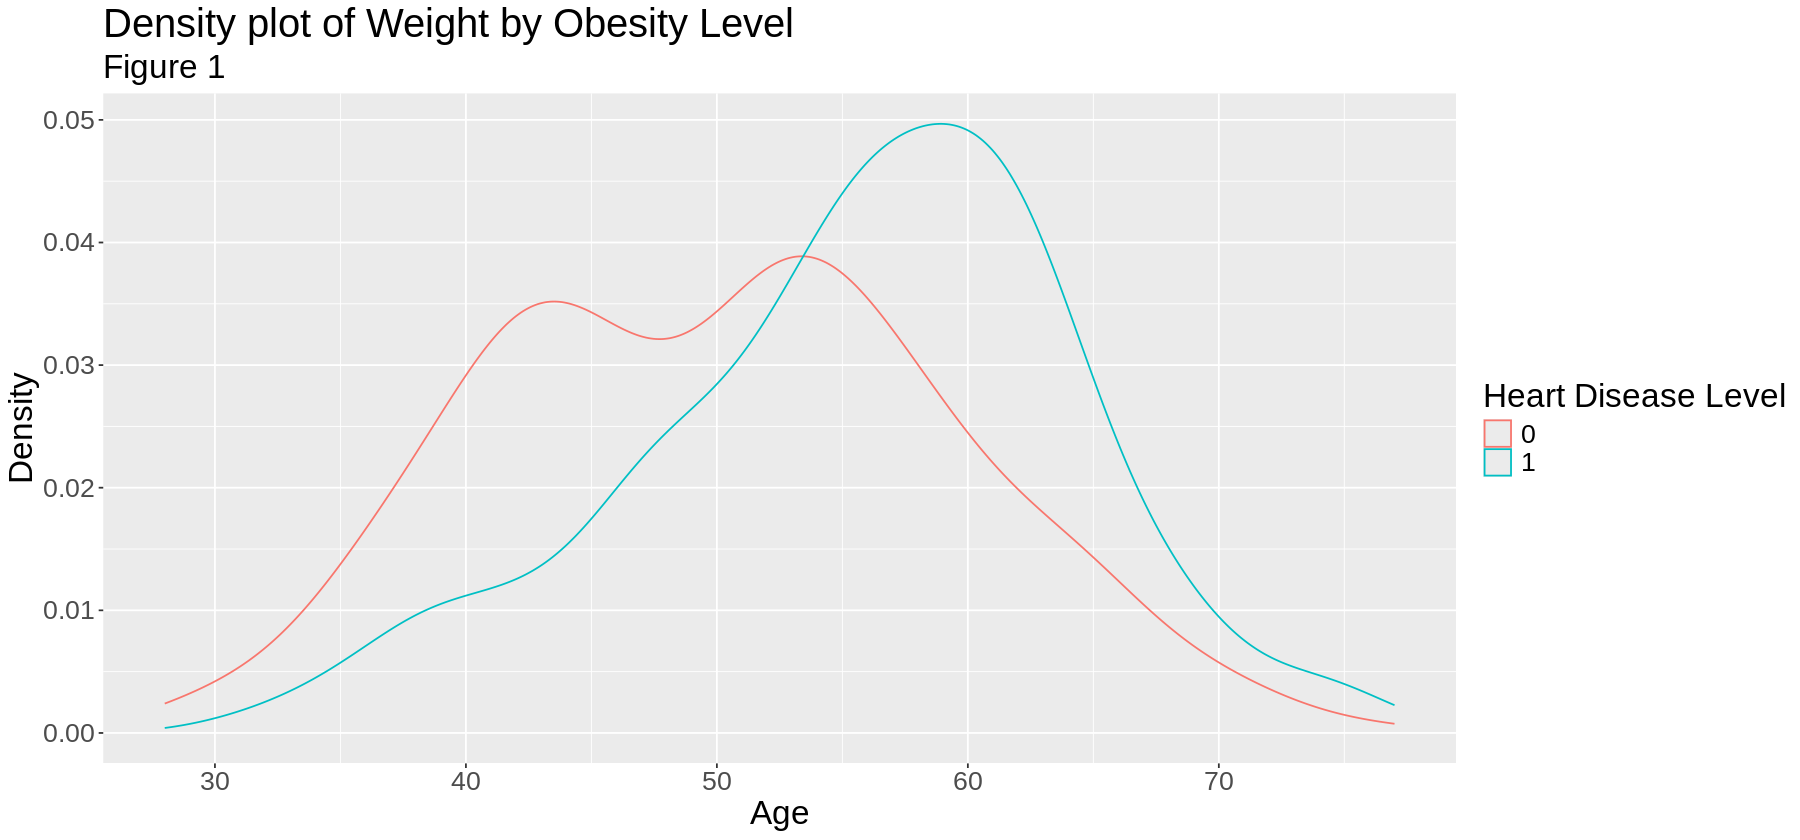

In [6]:
age_dist

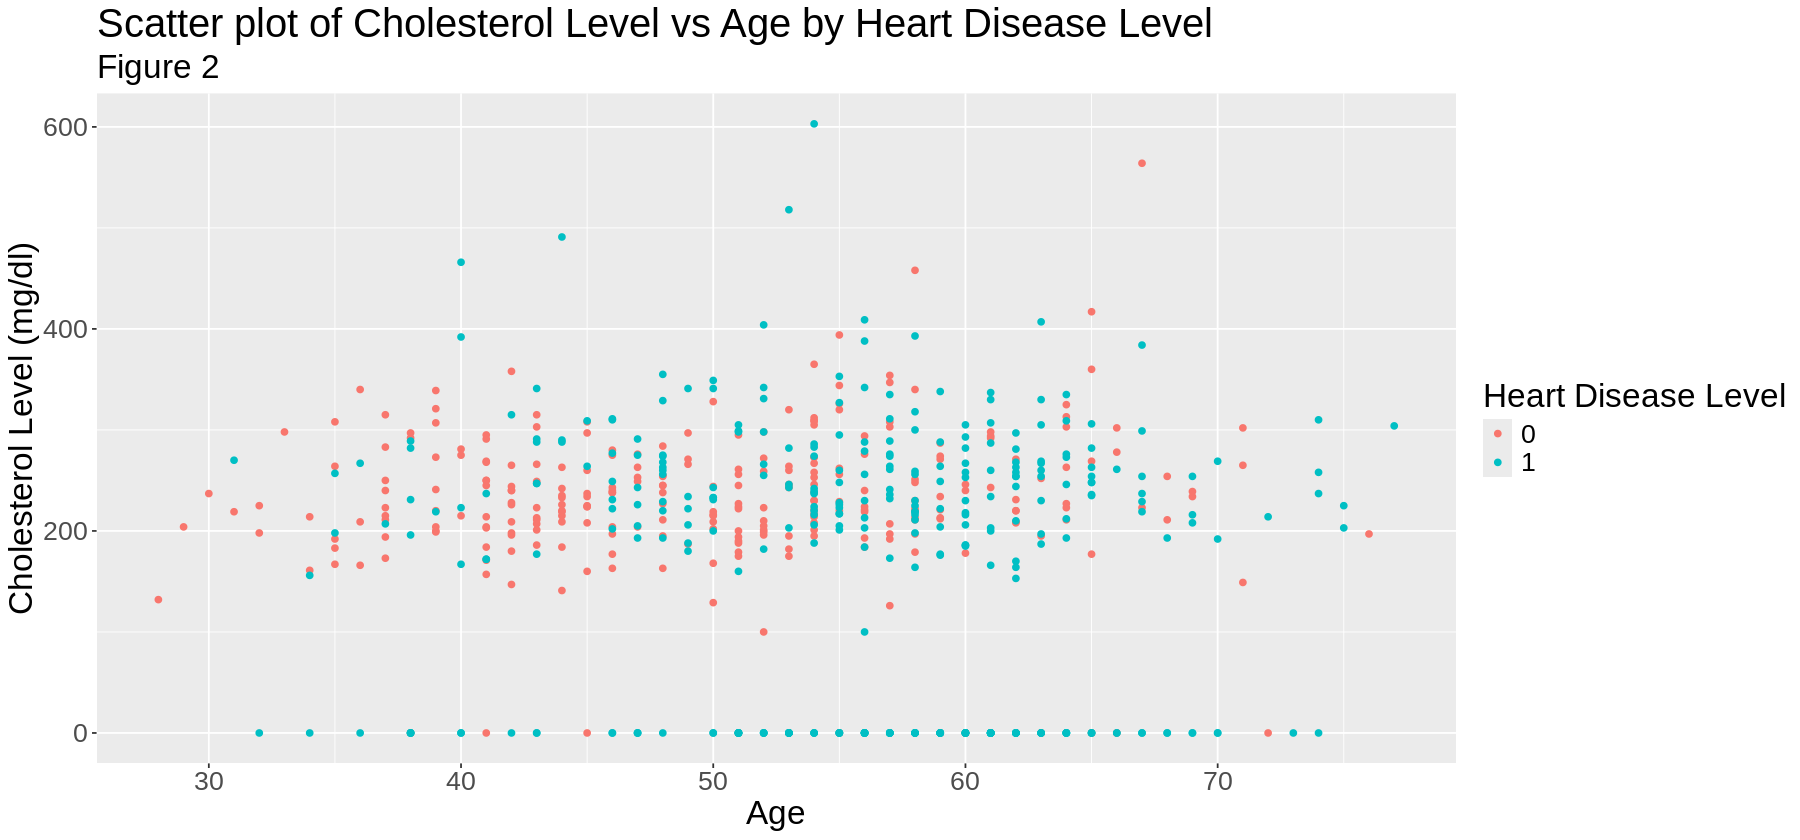

In [7]:
age_chol_plot

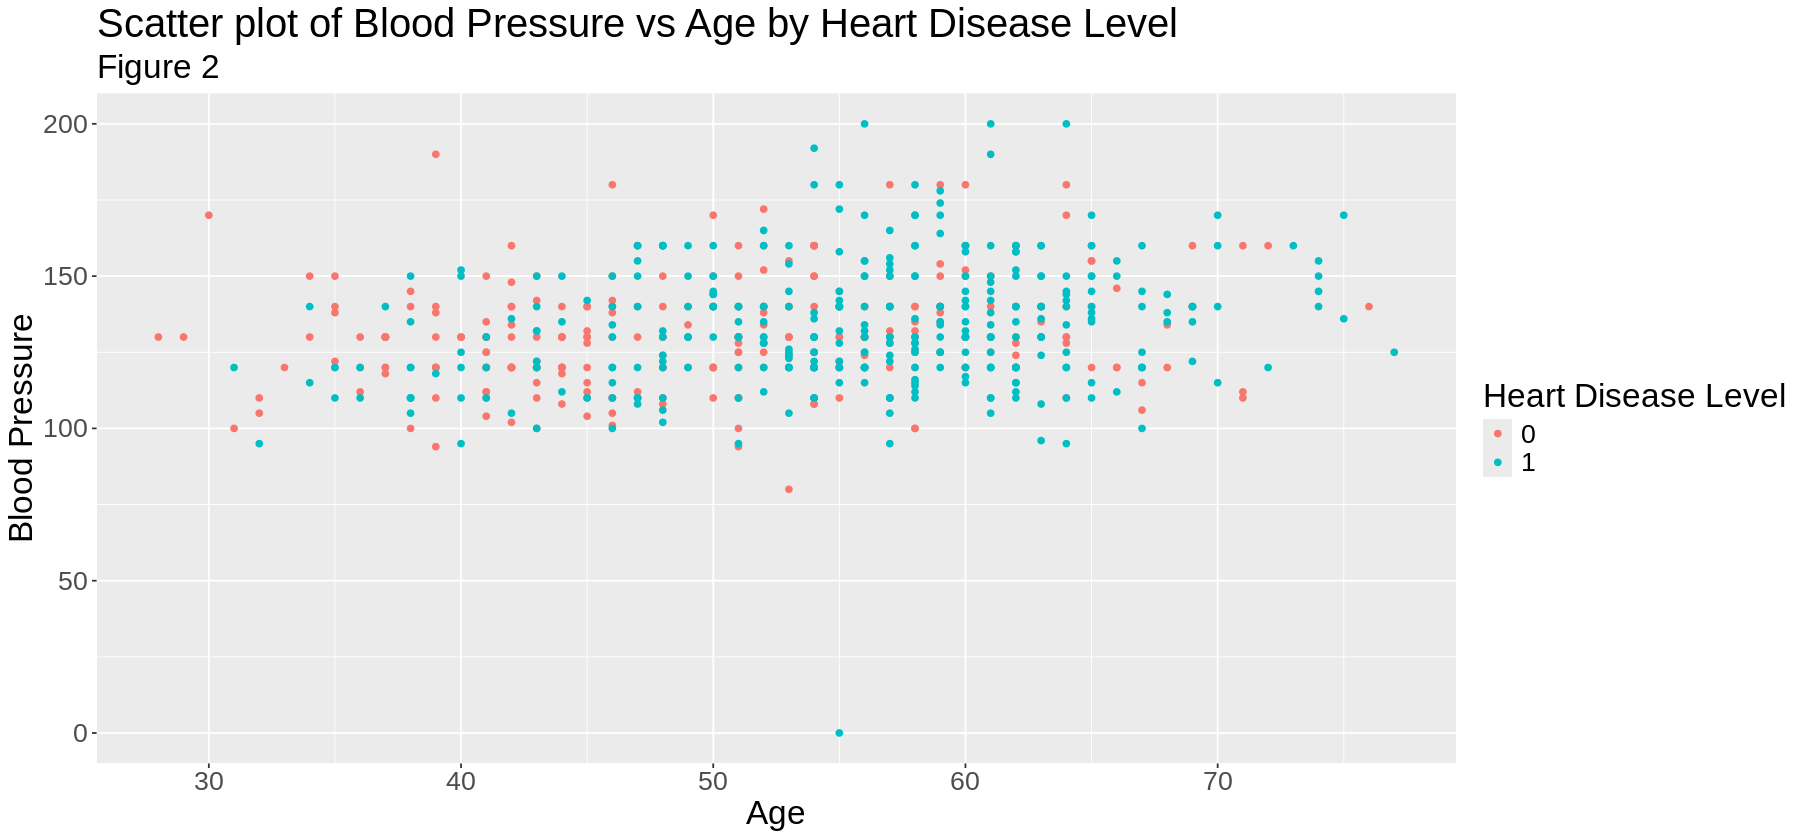

In [8]:
age_blood_plot

## Best K

Steps to find the best k : 
1. Create 5 splits for validation sets
2. Create the model and standardized recipe for tuning the classifier
3. Choose 15 values for k (from 1 - 15)
4. Create the workflow to get the accuracy for each value of k

In [9]:
colnames(heart_disease)

[1] "age"      "sex"      "trestbps" "chol"     "num"

In [10]:
set.seed(199) 

heart_vfold <- vfold_cv(heart_train, v = 5, strata = num)

heart_spec <- nearest_neighbor(weight_fun = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")

heart_recipe <- recipe(num ~ ., data = heart_train) |>
                step_scale(all_predictors()) |>
                step_center(all_predictors())  

k_vals <- tibble(neighbors = seq(from = 1, to = 15, by = 1))

k_data <- workflow() |>
        add_recipe(heart_recipe) |>
        add_model(heart_spec) |>
        tune_grid(resamples = heart_vfold, grid = k_vals) |>
        collect_metrics() |>
        filter(.metric == "accuracy")

k_data

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.6602194,5,0.008235038,Preprocessor1_Model01
2,accuracy,binary,0.6602194,5,0.008235038,Preprocessor1_Model02
3,accuracy,binary,0.6858710,5,0.012142854,Preprocessor1_Model03
4,accuracy,binary,0.6842581,5,0.012781621,Preprocessor1_Model04
5,accuracy,binary,0.6779226,5,0.018500729,Preprocessor1_Model05
6,accuracy,binary,0.6779226,5,0.018500729,Preprocessor1_Model06
7,accuracy,binary,0.6858968,5,0.011696609,Preprocessor1_Model07
8,accuracy,binary,0.6890968,5,0.011730977,Preprocessor1_Model08
9,accuracy,binary,0.6779097,5,0.015546240,Preprocessor1_Model09


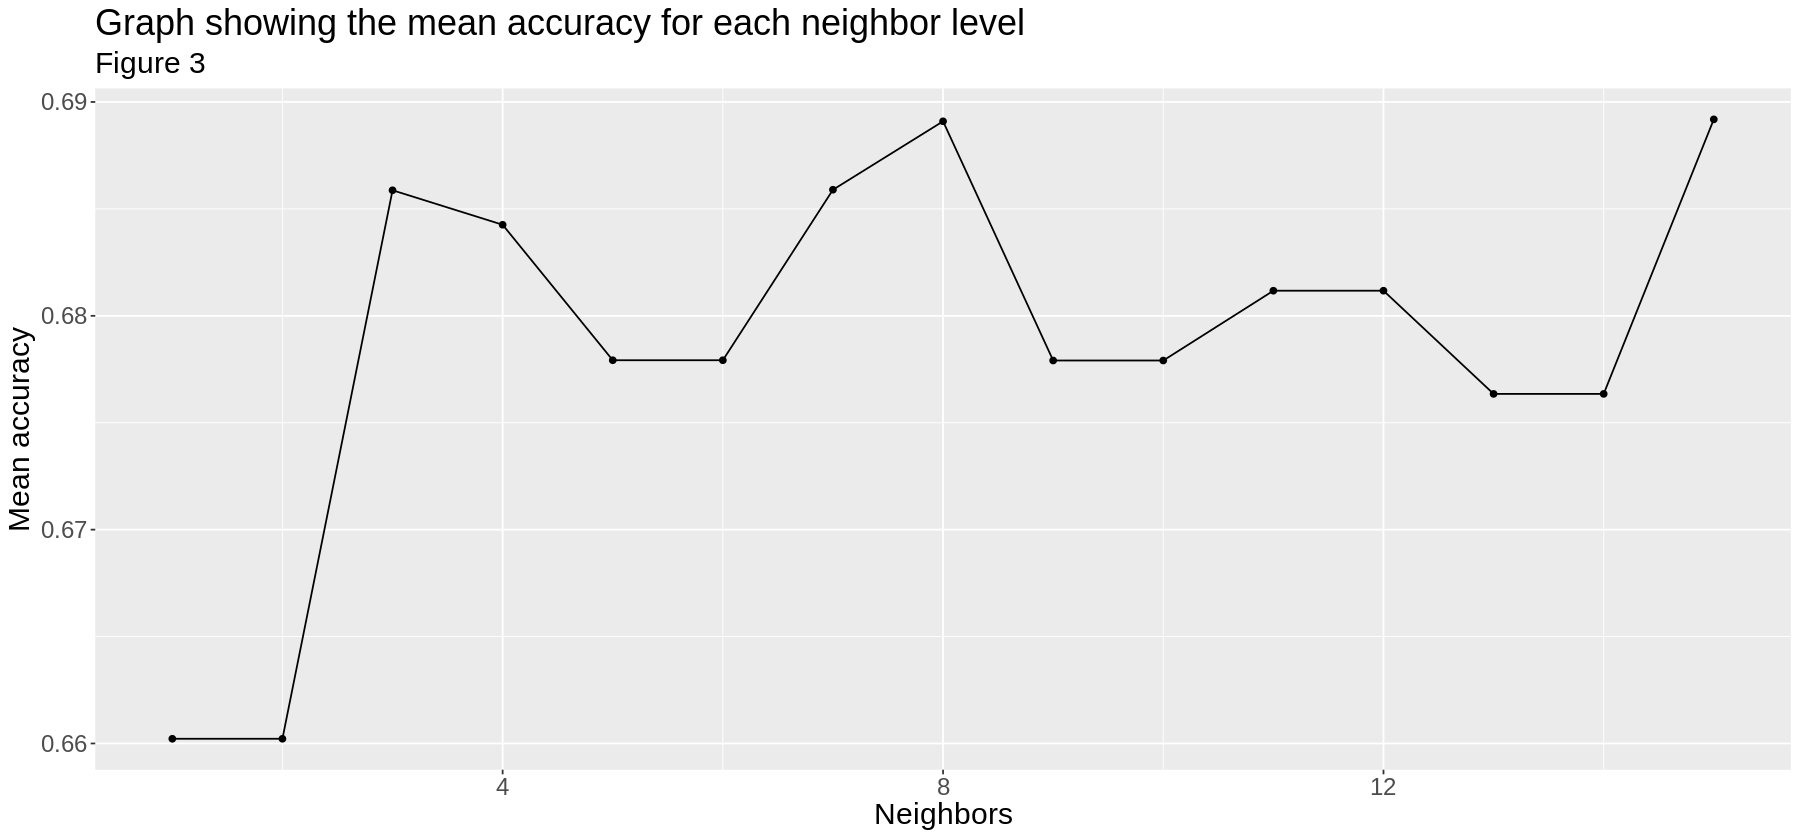

In [11]:
k_plot <- ggplot(k_data, aes(x = neighbors, y = mean)) +
            geom_line() +
            geom_point() +
            labs(x = "Neighbors", 
                 y = "Mean accuracy", 
                 title = "Graph showing the mean accuracy for each neighbor level", 
                 subtitle = "Figure 3") +
            theme(text = element_text(size = 18))

k_plot

In [12]:
k_min <- k_data |>
            arrange(desc(mean)) |>
            slice(1) |>
            pull(neighbors)

k_min

[1] 15

## Building the model using the min k

In [13]:
heart_spec_known <- nearest_neighbor(weight_fun = "rectangular", neighbors = 8) |>
            set_engine("kknn") |>
            set_mode("classification")

heart_fit <- workflow() |>
        add_recipe(heart_recipe) |>
        add_model(heart_spec) |>
        fit(heart_train)


Warning message:
“tune samples were requested but there were 624 rows in the data. 619 will be used.”


## Testing the model

In [14]:
set.seed(199)
predictions <- predict(heart_fit, heart_test) |>
                bind_cols(heart_test)

print("Table 5")
predictions

[1] "Table 5"


.pred_class,age,sex,trestbps,chol,num
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,63,1,145,233,0
1,67,1,160,286,1
1,56,1,120,236,0
1,57,1,150,168,0
1,54,1,140,239,0
1,48,0,130,275,0
1,58,0,150,283,0
1,58,1,120,284,1
1,58,1,132,224,1


In [15]:
heart_metrics <- predictions |>
                metrics(truth = num, estimate = .pred_class)

heart_conf_mat <- predictions |>
                conf_mat(truth = num, estimate = .pred_class)


heart_metrics

heart_conf_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.552381
kap,binary,0.000000


          Truth
Prediction   0   1
         0   0   0
         1  94 116